#### Задача : Проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения

### Описание данных

- date – дата совершения события
- event - событие
- 
        -	app_install – установка приложения
        -	app_start – открыть приложения
        -	registration – зарегистрироваться 
        -	search – перейти на страницу поиска товаров (каталог)
        -	open_item – открыть товар
        -	choose_item – отправить товар в корзину
        -	tap_basket – перейти в корзину
        -	purchase – подтверждение покупки
- gender – пол пользователя
- os_name – платформа пользователя
- city – город пользователя
- device_id – идентификатор устройства пользователя
- urm_source – канал, с которого пришел пользователь
- 
        -	yandex-direct – Яндекс директ
        -	google_ads – реклама в Google
        -	vk_ads – реклама в ВК
        -	instagram_ads – реклама в instagram
        -	facebook_ads – реклама в facebook
        -	referral – акция «приведи друга»
        -	Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  
- purchase_sum – стоимость покупки (при совершении события ‘purchase’)


In [3]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [4]:
data = pd.read_csv('case_data .csv')

In [5]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


## 1. Проанализируем поведение пользователей в сервисе по доставке продуктов на дом

In [6]:
# Приведем столбец с датой к нужному формату данных
data.date = pd.to_datetime(data.date)

# DAU

In [7]:
# Посчитаем DAU - количество уникальных пользователей в каждый день
dau = data.groupby('date', as_index=False).agg({'device_id':'nunique'})

In [8]:
dau

,date,device_id
0,2020-01-01,4445
1,2020-01-02,5104
2,2020-01-03,5144
3,2020-01-04,4925
4,2020-01-05,5608
...,...,...
86,2020-03-27,7810
87,2020-03-28,6469
88,2020-03-29,5935
89,2020-03-30,5705


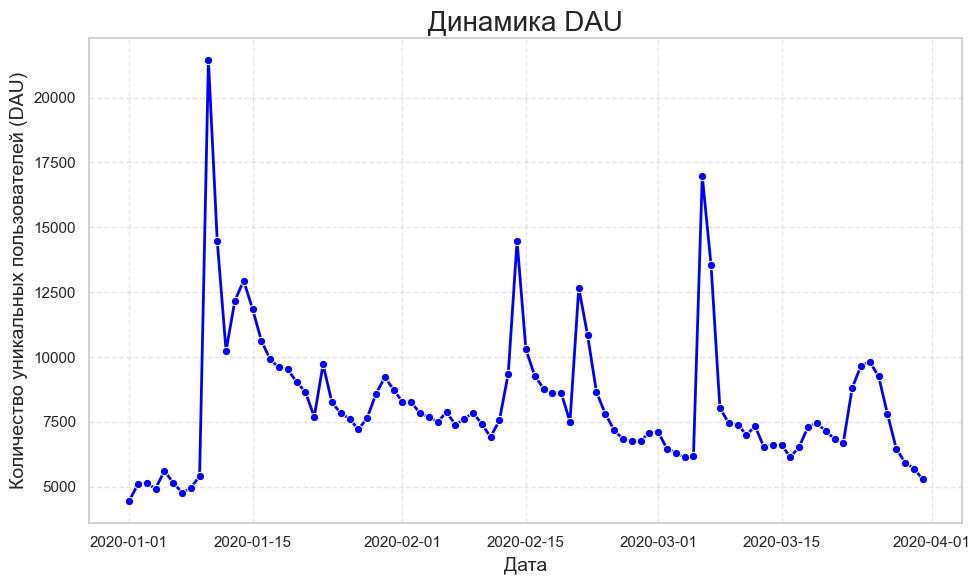

In [10]:
# Создание графика DAU в Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=dau, 
    x="date", 
    y="device_id", 
    marker="o", 
    color="blue", 
    linewidth=2
)

# Настройка внешнего вида
plt.title("Динамика DAU", fontsize=20)
plt.xlabel("Дата", fontsize=14)
plt.ylabel("Количество уникальных пользователей (DAU)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Показ графика
plt.show()

[Смотреть интерактивный график DAU](./dau_graph.html)

## Выводы:
        Анализ ежедневной аудитории (DAU) показал, что количество активных пользователей в приложении преимущественно стабильно около цифры 7-8 тысяч юзеров. 
        
        Однако отмечены аномалии в такие даты, как 10 января, 14 и 21 февраля, а также 6 марта 2020 года. Эти выбросы могут быть связаны с акциями, маркетинговыми кампаниями, праздниками или внешними событиями, которые временно повлияли на поведение пользователей

# Воронка

In [29]:
# Посчитаем количество уникальных пользователей на каждом этапе (event) воронки
funnel = data.groupby("event")["device_id"].nunique().reset_index()
funnel.columns = ["event", "unique_users"]

funnel = funnel.sort_values('unique_users', ascending=False)
funnel

,event,unique_users
1,app_start,190884
5,search,184488
2,choose_item,155691
0,app_install,154597
6,tap_basket,125414
4,register,78310
3,purchase,70875


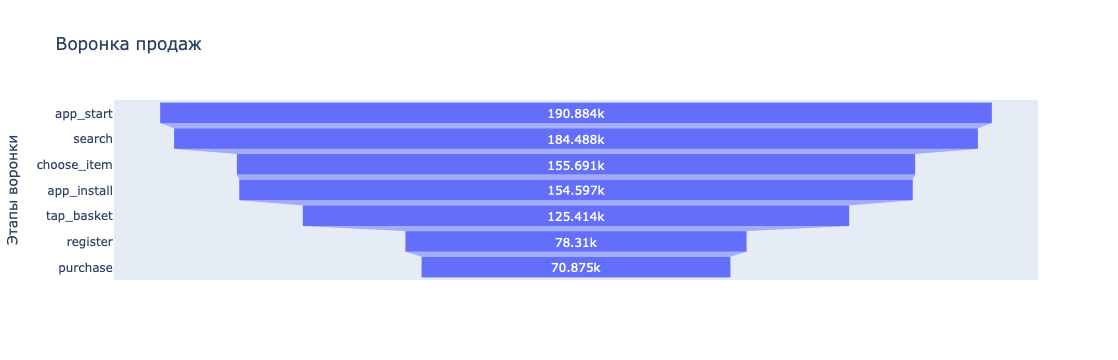

In [30]:
# Построение графика воронки
fig = px.funnel(funnel, x="unique_users", y="event", title="Воронка продаж")

# Настройка внешнего вида
fig.update_layout(
    xaxis_title="Количество уникальных пользователей",
    yaxis_title="Этапы воронки",
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=False),
)

# Отображение графика
fig.show()

## Выводы:
        Общее количество уникальных пользователей: 190 884, начавших с запуска приложения.
        
        Самая низкая конверсия наблюдается на этапе регистрации из 125 414 пользователей, добавивших товары в корзину, зарегистрировались всего 78 310 юзеров (конверсия ~62.5%). 
        Здесь, вероятно, причина связана с тем, что пользователи, наполнив корзину товарами, не регестрировались до этого. 
        Возможно, что-то не так со страницей регистарции (слишком долгая, нужно много подтверждений)

## 2. Оценим эффективность каналов привлечения юзеров

# Количество уникальных пользователей по каналу

In [31]:
# Подсчёт количества уникальных пользователей по каналу привлечения (urm_source)
user_counts_by_channel = data.groupby("utm_source")["device_id"].nunique().reset_index()
user_counts_by_channel.columns = ["utm_source", "unique_users"]
user_counts_by_channel = user_counts_by_channel.sort_values('unique_users', ascending=False)

user_counts_by_channel

,utm_source,unique_users
0,-,52273
6,yandex-direct,40712
2,google_ads,38096
5,vk_ads,34086
3,instagram_ads,31048
1,facebook_ads,25959
4,referal,15926


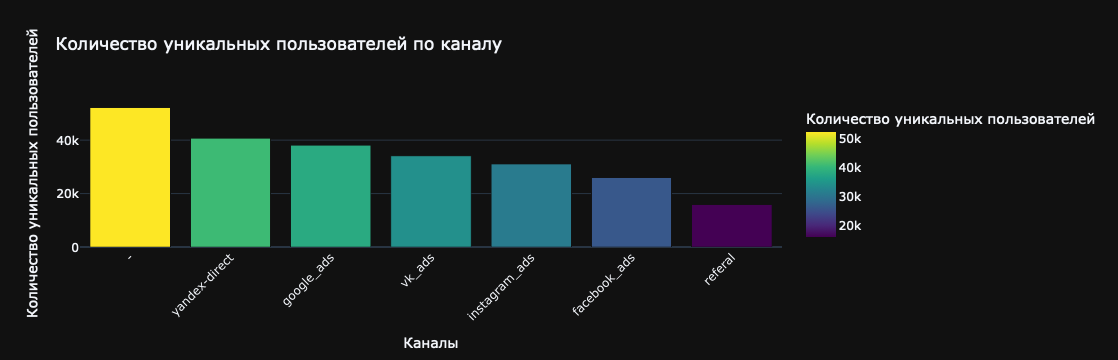

In [32]:
# Построение графика с количеством уникальных пользователей по каналу
fig = px.bar(user_counts_by_channel, x="utm_source", y="unique_users",
             title="Количество уникальных пользователей по каналу",
             labels={"utm_source": "Канал", "unique_users": "Количество уникальных пользователей"},
             color="unique_users", color_continuous_scale="Viridis")

# Настройка внешнего вида
fig.update_layout(
    xaxis_title="Каналы",
    yaxis_title="Количество уникальных пользователей",
    xaxis_tickangle=-45,
    template="plotly_dark"  # Можно использовать другую тему, если нужно
)

# Отображение графика
fig.show()

## Выводы:
        Наибольшее количество пользователей пришло из неизвестного или прямого источника (-): 52 273 пользователя (27.4% от общего числа). Это может включать прямые заходы в приложение, органический поиск или некорректно настроенные UTM-метки. Рекомендуется уточнить настройки трекинга.
        
        Реклама в Yandex.Direct привлекла 40 712 пользователей (21.4%), что делает её самым эффективным платным каналом.
        
        Реклама на Facebook оказалась менее результативной, привлекла только 25 959 пользователей (13.6%).
        
        Реферальная программа привлекла наименьшее количество пользователей: 15 926 (8.3%), что может свидетельствовать о недостаточной мотивации пользователей делиться приложением.



# Общая сумма покупок по каналам

In [33]:
# Подсчёт общей суммы покупок по каналу (urm_source)
purchase_sum_by_channel = data.groupby("utm_source")["purchase_sum"].sum().reset_index()
purchase_sum_by_channel.columns = ["utm_source", "total_purchase_sum"]
purchase_sum_by_channel = purchase_sum_by_channel.sort_values('total_purchase_sum', ascending=False)

purchase_sum_by_channel

,utm_source,total_purchase_sum
0,-,21449749.5
5,vk_ads,16389652.5
3,instagram_ads,14546969.0
6,yandex-direct,13915368.0
2,google_ads,12868276.0
1,facebook_ads,12249901.0
4,referal,8837044.5


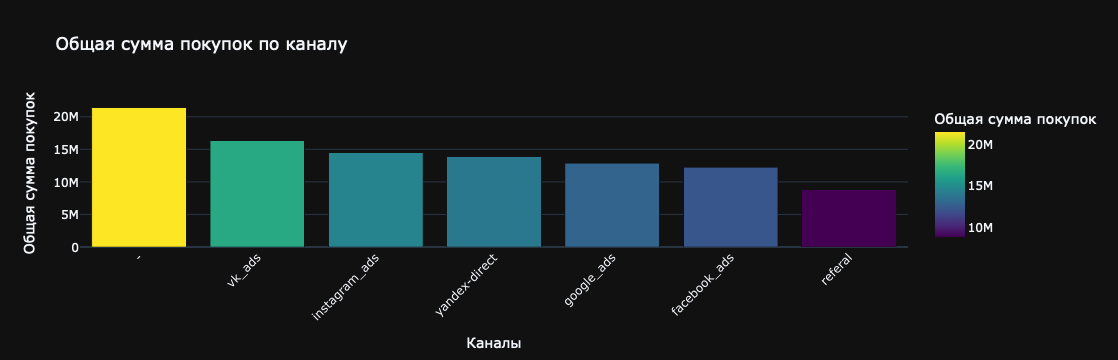

In [34]:
# Построение графика с общей суммой покупок по каналу
fig = px.bar(purchase_sum_by_channel, x="utm_source", y="total_purchase_sum",
             title="Общая сумма покупок по каналу",
             labels={"utm_source": "Канал", "total_purchase_sum": "Общая сумма покупок"},
             color="total_purchase_sum", color_continuous_scale="Viridis")

# Настройка внешнего вида
fig.update_layout(
    xaxis_title="Каналы",
    yaxis_title="Общая сумма покупок",
    xaxis_tickangle=-45,
    template="plotly_dark"  # Можно использовать другую тему, если нужно
)

# Отображение графика
fig.show()

## Выводы:
        Наибольшая сумма покупок приходится на неизвестный или прямой источник (-): 21 449 749.5 руб. (26.3% от общей суммы).

        Реклама в VK оказалась самым прибыльным платным каналом: 16 389 652.5 руб. (20.1%).

        Реклама на Facebook привлекла меньше всего дохода среди плтаных каналов привлечения: 12 249 901 руб. (15%).

# Рекомендации к данному сервису:
        Оптимизировать процесс регистрации, добавив возможность авторизации через социальные сети

        Переработать реферальную программу, чтобы сделать её более привлекательной для пользователей

        Продолжать активно инвестировать в VK и Instagram Ads, как наиболее прибыльные каналы, с одновременной оптимизацией кампаний в Yandex.Direct и Google Ads

        Провести анализ Facebook Ads для улучшения их эффективности